In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,SimpleRNN,GRU,Bidirectional,LSTM,Dense,Dropout,LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re

2025-12-02 14:36:39.938308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764686200.123016      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764686200.178571      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Loading Datasets

In [10]:
## load a subset of the training data
with bz2.BZ2File("/kaggle/input/amazonreviews/train.ft.txt.bz2") as f:
    training_data = [f.readline().decode('utf-8').strip() for _ in range(12000)]

## load a subset of the test data
with bz2.BZ2File("/kaggle/input/amazonreviews/test.ft.txt.bz2") as f:
    test_data = [f.readline().decode('utf-8').strip() for _ in range(3000)]

print("Training data subset size:",len(training_data))
print("Test data subset size:",len(test_data))

Training data subset size: 12000
Test data subset size: 3000


In [11]:
training_data[0:5]

['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 '__label__2 Amazing!: This sound

## Preparing Dataset

In [12]:
training_labels = [int(re.findall(r'__label__(\d)',line)[0]) for line in training_data]
training_texts = [re.sub(r'__label__\d','', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)',line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d','', line) for line in test_data]

training_labels = [0 if label==1 else 1 for label in training_labels]
test_labels = [0 if label==1 else 1 for label in test_labels]

In [13]:
print(test_labels[:4])

print("\n\n",test_texts[:4])

[1, 1, 0, 1]


 [' Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', " One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of

## Text Cleaning

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords.words('english')

def clean_text(text):
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    ## convert to lowercase
    text = text.lower()

    ## Remove non-alphabetic characters (keep spaces)
    text = re.sub(r"^a-z\s",'',text)

    ## Tokenize and remove stopwords,apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]

    ## join words back into a string
    return " ".join(words)

## Apply function to training and test texts
training_texts = [clean_text(text) for text in training_texts]
test_texts = [clean_text(text) for text in test_texts]

In [16]:
clean_text("My phone number is 6582685 ")

'phone number 6582685'

In [17]:
training_texts[0]

'stune even non-gamer: sound track beautiful! paint seneri mind well would recomend even peopl hate vid. game music! play game chrono cross game ever play best music! back away crude keyboard take fresher step grate guitar soul orchestras. would impress anyon care listen! ^_^'

## Tokenization

In [19]:
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_texts)

X_train = tokenizer.texts_to_sequences(training_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train,maxlen=max_sequence_length)
X_test = pad_sequences(X_test,maxlen=max_sequence_length)

In [20]:
X_train[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  19, 536,  88, 223, 993, 301,  18,   9,  19,
         76, 405,  70,  54,  68,  70,  70,  43,  68,  25,  54,  39, 177,
         69, 777, 984, 896,   9, 564, 151, 288, 153],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  25, 765,  43,   3,  83,  62,  45,  25, 413, 15

In [22]:
X_train = np.array(X_train)
print(X_train.shape)

X_test = np.array(X_test)
print(X_test.shape)

y_train = np.array(training_labels)
print(y_train.shape)

y_test = np.array(test_labels)
print(y_test.shape)

(12000, 100)
(3000, 100)
(12000,)
(3000,)


## Training RNN

In [25]:
model = Sequential([
    Embedding(input_dim = max_words,output_dim=300,input_shape=(max_sequence_length,)),
    SimpleRNN(128,return_sequences=True,dropout=0.3),
    LayerNormalization(),
    SimpleRNN(128,dropout=0.3),
    LayerNormalization(),
    Dropout(0.3),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 300)       │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100, 128)       │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 100, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,641 (1.51 MB)

 Trainable params: 396,641 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=5e-5),metrics=['accuracy'])

In [33]:
## Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Train model
history = model.fit(X_train,y_train,epochs=50,batch_size=512,validation_data=(X_test,y_test),callbacks=early_stopping,verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 514ms/step - accuracy: 0.5032 - loss: 0.7552 - val_accuracy: 0.4847 - val_loss: 0.6976
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 529ms/step - accuracy: 0.5052 - loss: 0.7429 - val_accuracy: 0.4800 - val_loss: 0.6992
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step - accuracy: 0.5081 - loss: 0.7221 - val_accuracy: 0.4813 - val_loss: 0.6972
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - accuracy: 0.5033 - loss: 0.7230 - val_accuracy: 0.4843 - val_loss: 0.6971
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.5265 - loss: 0.7110 - val_accuracy: 0.5077 - val_loss: 0.6939
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 504ms/step - accuracy: 0.5098 - loss: 0.7122 - val_accuracy: 0.5073 - val_loss: 0.6926
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.5288 - loss: 0.7047 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - accuracy: 0.5390 - loss: 0.6981 - val_accu

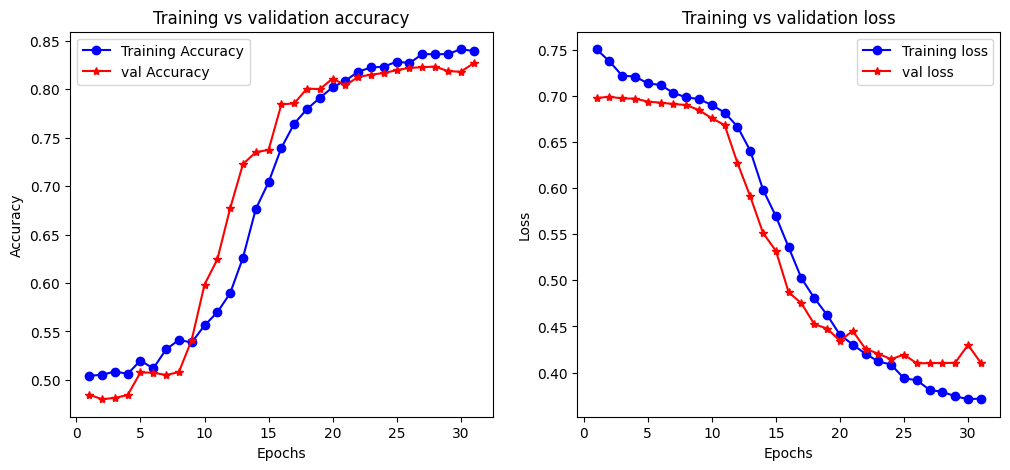

In [34]:
## Extract values from history
epochs = range(1,len(history.history['accuracy'])+1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

## Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,train_acc,'bo-',label='Training Accuracy')
plt.plot(epochs,val_acc,'r*-',label='val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs validation accuracy')
plt.legend()

## Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'bo-',label='Training loss')
plt.plot(epochs,val_loss,'r*-',label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs validation loss')
plt.legend()

In [35]:
### Model Evaluation
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test,y_pred)
print("classification report")
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Confusion Matrix:
[[1164  273]
 [ 261 1302]]
classification report
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1437
           1       0.83      0.83      0.83      1563

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



## Training LSTM

In [36]:
model = Sequential([
    Embedding(input_dim = max_words,output_dim=300,input_shape=(max_sequence_length,)),
    Bidirectional(LSTM(128,return_sequences=True,dropout=0.2)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(128,dropout=0.2)),
    LayerNormalization(),
    Dropout(0.3),
    
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 300)       │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 100, 256)       │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,151,073 (4.39 MB)

 Trainable params: 1,151,073 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=5e-5),metrics=['accuracy'])

## Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Train model
history = model.fit(X_train,y_train,epochs=50,batch_size=512,validation_data=(X_test,y_test),callbacks=early_stopping,verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.4995 - loss: 0.8808 - val_accuracy: 0.5430 - val_loss: 0.6912
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5253 - loss: 0.7427 - val_accuracy: 0.5437 - val_loss: 0.6849
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5509 - loss: 0.6985 - val_accuracy: 0.6173 - val_loss: 0.6697
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5744 - loss: 0.6822 - val_accuracy: 0.6453 - val_loss: 0.6544
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6123 - loss: 0.6523 - val_accuracy: 0.6817 - val_loss: 0.6272
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6364 - loss: 0.6331 - val_accuracy: 0.7117 - val_loss: 0.5879
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6837 - loss: 0.5903 - val_accuracy: 0.7347 - val_loss: 0.5348
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.7242 - loss: 0.5461 - val_accuracy: 0.7547 - val_loss:

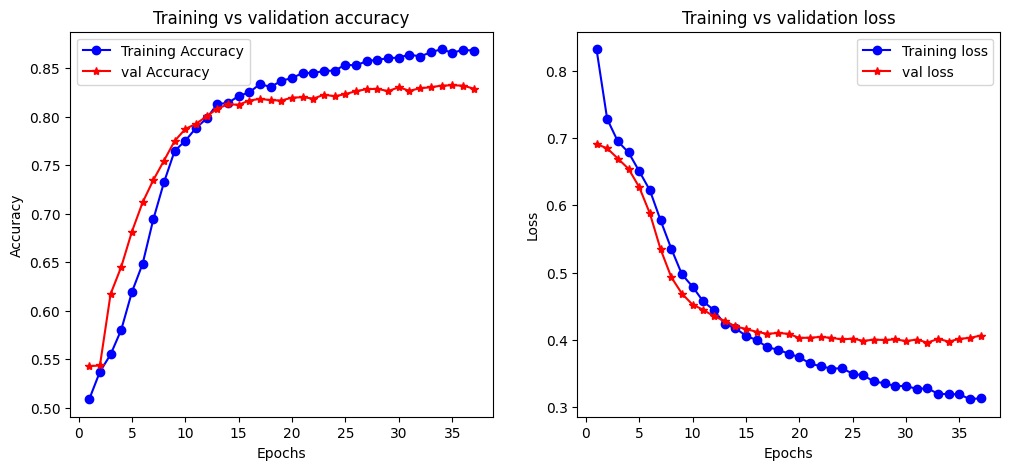

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step
Confusion Matrix:
[[1161  276]
 [ 236 1327]]
classification report
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1437
           1       0.83      0.85      0.84      1563

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [38]:
## Extract values from history
epochs = range(1,len(history.history['accuracy'])+1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

## Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,train_acc,'bo-',label='Training Accuracy')
plt.plot(epochs,val_acc,'r*-',label='val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs validation accuracy')
plt.legend()

## Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'bo-',label='Training loss')
plt.plot(epochs,val_loss,'r*-',label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs validation loss')
plt.legend()

plt.show()

### Model Evaluation
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test,y_pred)
print("classification report")
print(report)

## Training GRU

In [39]:
model = Sequential([
    Embedding(input_dim = max_words,output_dim=300,input_shape=(max_sequence_length,)),
    GRU(128,return_sequences=True,dropout=0.3,recurrent_dropout=0.2),
    LayerNormalization(),
    GRU(128,dropout=0.3,recurrent_dropout=0.2),
    LayerNormalization(),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

## compile model
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=5e-5),metrics=['accuracy'])

## Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Train model
history = model.fit(X_train,y_train,epochs=50,batch_size=512,validation_data=(X_test,y_test),callbacks=early_stopping,verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5135 - loss: 0.9224 - val_accuracy: 0.5540 - val_loss: 0.7546
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5432 - loss: 0.8223 - val_accuracy: 0.5847 - val_loss: 0.6989
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5641 - loss: 0.7598 - val_accuracy: 0.6127 - val_loss: 0.6649
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5738 - loss: 0.7339 - val_accuracy: 0.6203 - val_loss: 0.6489
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5882 - loss: 0.7066 - val_accuracy: 0.6363 - val_loss: 0.6346
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6064 - loss: 0.6943 - val_accuracy: 0.6440 - val_loss: 0.6248
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6119 - loss: 0.6798 - val_accuracy: 0.6513 - val_loss: 0.6150
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6311 - loss: 0.6575 - val_accuracy: 0.6623 - val_loss: 0.6023
Epo

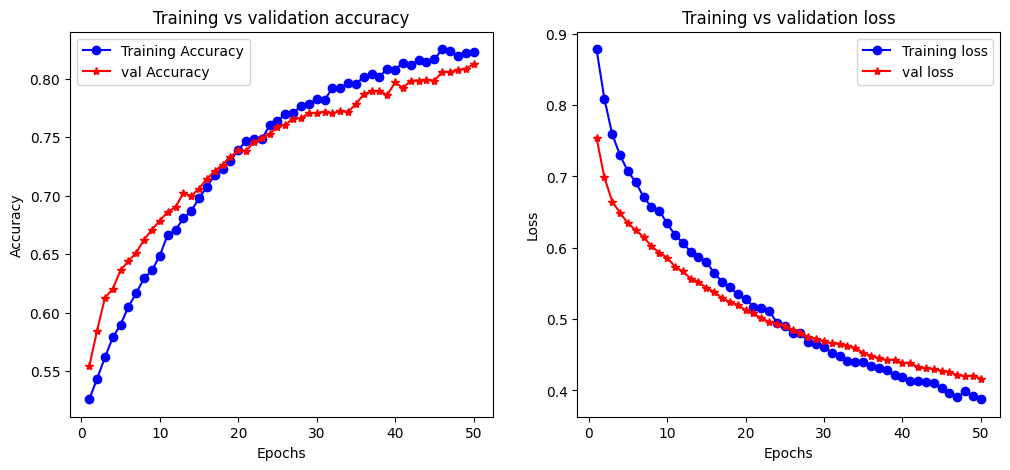

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
Confusion Matrix:
[[1141  296]
 [ 267 1296]]
classification report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1437
           1       0.81      0.83      0.82      1563

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



In [40]:
## Extract values from history
epochs = range(1,len(history.history['accuracy'])+1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

## Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,train_acc,'bo-',label='Training Accuracy')
plt.plot(epochs,val_acc,'r*-',label='val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs validation accuracy')
plt.legend()

## Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'bo-',label='Training loss')
plt.plot(epochs,val_loss,'r*-',label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs validation loss')
plt.legend()

plt.show()

### Model Evaluation
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test,y_pred)
print("classification report")
print(report)

## Detection Systems

In [43]:
def predict_sentiment(text,model,tokenizer,max_sequence_length=100):

    ## clearn the text
    text = clean_text(text)

    ## Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])

    ## Pad sequence
    padded_sequence = pad_sequences(sequence,maxlen=max_sequence_length)
    
    ## Predict sentiment
    prediction = model.predict(padded_sequence)[0][0]
    
    ## Check if pos or neg
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment,float(prediction)

## Example:-
test_sentences = [
    "I love this product! It's amazing",
    "This is the worst service I have ever experienced",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment , confidence = predict_sentiment(sentence,model,tokenizer)
    print(f"Text: {sentence}\Predicted sentiment: {sentiment} (confidence:{confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Text: I love this product! It's amazing\Predicted sentiment: Positive 😊 (confidence:0.9711)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Text: This is the worst service I have ever experienced\Predicted sentiment: Negative 😡 (confidence:0.0071)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Text: The movie was okay, not great but not terrible either.\Predicted sentiment: Negative 😡 (confidence:0.4489)



In [44]:
model.save("lstm_model.h5")

import pickle

with open("tokenizer.pkl","wb") as f:
    pickle.dump(tokenizer,f)

In [45]:
import tensorflow as tf
print(tf.__version__)

2.18.0
